## Sagnac Frequency - Backscatter Correction - RZ Backscatter

Explore the longterm behaviour of the RV sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [8]:
config = {}

config['ring'] = "Z"

config['delta'] = 60

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

# since PD for monobeams at RZ
# config['tbeg'] = UTCDateTime("2024-07-29 16:00")
# config['tend'] = UTCDateTime().now()
# flim1, flim2 = 553.569, 553.575

# switch of PDs for monobeams at RZ
# config['tbeg'] = UTCDateTime("2024-08-01 16:00")
config['tbeg'] = UTCDateTime("2024-08-02 00:00")
config['tend'] = UTCDateTime("2024-08-05 06:00")
flim1, flim2 = 553.5705, 553.578

# switch of PDs for monobeams at RZ & new control loop
config['tbeg'] = UTCDateTime("2024-08-09 11:00")
config['tend'] = UTCDateTime("2024-08-20 12:00")
flim1, flim2 = 553.569, 553.577

# switch of PDs for monobeams at RZ & new control loop
# config['tbeg'] = UTCDateTime("2024-08-09 11:00")
config['tbeg'] = UTCDateTime("2024-08-22 10:00")
config['tend'] = UTCDateTime("2024-08-28 00:00")
# config['tend'] = UTCDateTime().now()
flim1, flim2 = 553.568, 553.580

# path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"


### Load backscatter data

In [9]:
if config['delta'] == 60:
    bs = __load_backscatter_data(config['tbeg'], config['tend']+86400, config['ring'], config['path_to_data'], label="")
else:
    bs = __load_backscatter_data(config['tbeg'], config['tend']+86400, config['ring'], config['path_to_data'], label=config['delta'])

# add time seconds
bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - config['tbeg'])

# cut to time period
bs = bs[(bs.time1 > config['tbeg']) & (bs.time2 < config['tend'])]

 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJZ_20240828_00:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJZ_20240828_01:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJZ_20240828_02:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJZ_20240828_03:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJZ_20240828_04:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJZ_20240828_05:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJZ_20240828_06:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJZ_20240828_07:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJZ_20240828_08:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/FJZ_20240828_09:00:00_backscatter.pkl
 -> failed: /home/an

### Compute Backscatter (again)

In [10]:
from functions.backscatter_correction import __backscatter_correction

In [11]:
# compute backscatter corrected signal
bs['fj_bs'], _, _ = __backscatter_correction(bs.f1_ac / bs.f1_dc,
                                             bs.f2_ac / bs.f2_dc,
                                             np.unwrap(bs.f1_phw) - np.unwrap(bs.f2_phw),
                                             bs.fj_fs,
                                             np.nanmedian(bs.fj_fs),
                                             cm_filter_factor=1.033,
                                             )


(553.568, 553.58)

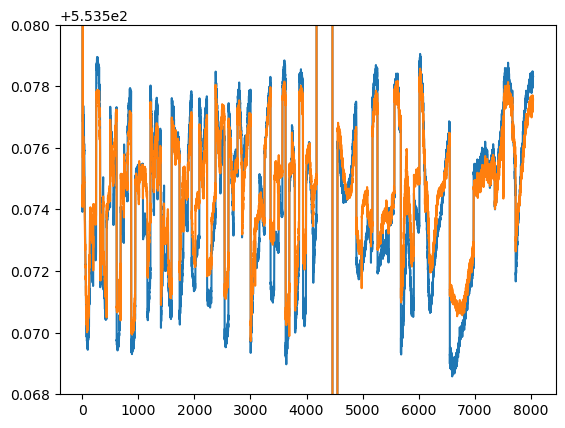

In [12]:
plt.plot(bs.fj_fs)
plt.plot(bs.fj_bs)

plt.ylim(flim1, flim2)

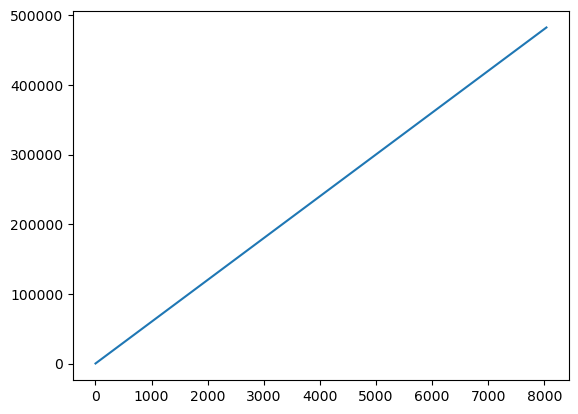

In [25]:
plt.plot(bs.time_sec)

### Cut corrupt data periods

In [13]:
bs['fj_fs'] = np.where((bs.fj_fs > flim2), np.nan, bs.fj_fs)
bs['fj_fs'] = np.where((bs.fj_fs < flim1), np.nan, bs.fj_fs)

bs['fj_bs'] = np.where((bs.fj_bs > flim2), np.nan, bs.fj_bs)
bs['fj_bs'] = np.where((bs.fj_bs < flim1), np.nan, bs.fj_bs)

In [14]:
def __time_spans_to_nan(bs, time_spans):

    from numpy import where, nan

    for t1, t2 in time_spans:
        bs['fj_fs'] = where((bs.time1 > t1) & (bs.time1 < t2), nan, bs.fj_fs)
        bs['fj_bs'] = where((bs.time1 > t1) & (bs.time1 < t2), nan, bs.fj_bs)

    return bs

In [15]:
time_spans = [("2024-06-20T12:00", "2024-06-21T12:00"),
             ]

bs = __time_spans_to_nan(bs, time_spans)

In [16]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)

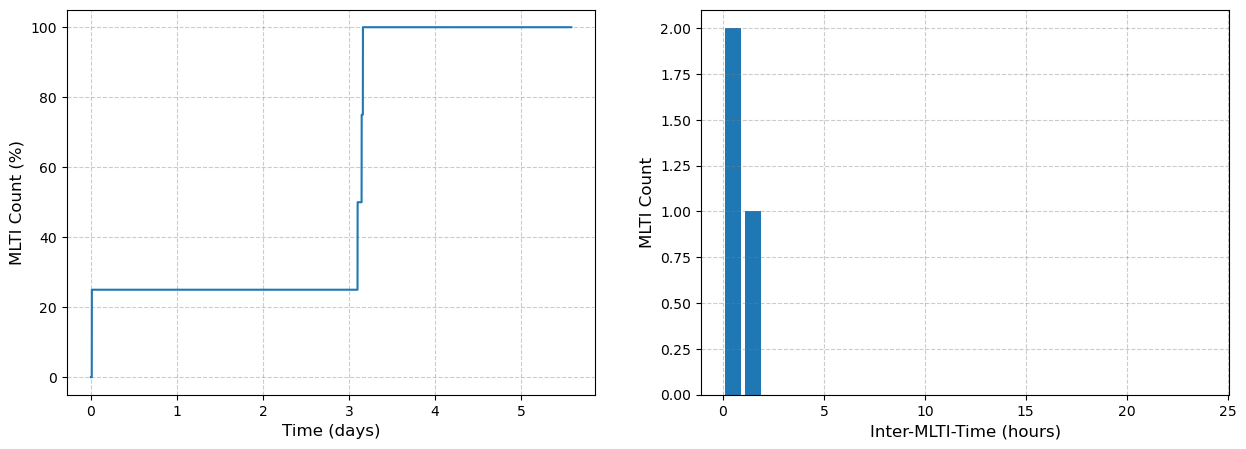

In [17]:
from functions.get_mlti_statistics import __get_mlti_statistics

mlti_stats = __get_mlti_statistics(mlti, config['tbeg'], config['tend'], intervals=True, plot=True, ylog=False)


### Apply special filter sections

In [18]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [19]:
from functions.smoothing import __smooth

n_minutes = 60

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [20]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

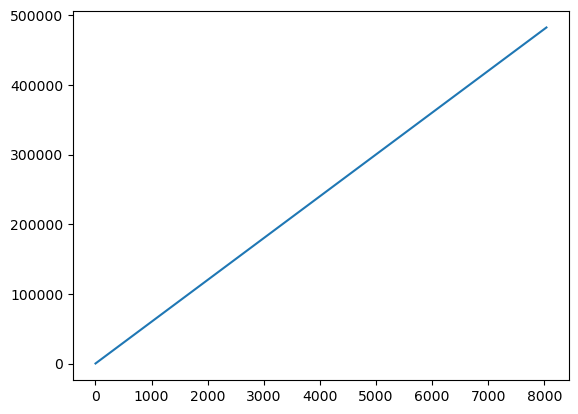

### Checkup Plot

/tmp/ipykernel_61080/1830721788.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


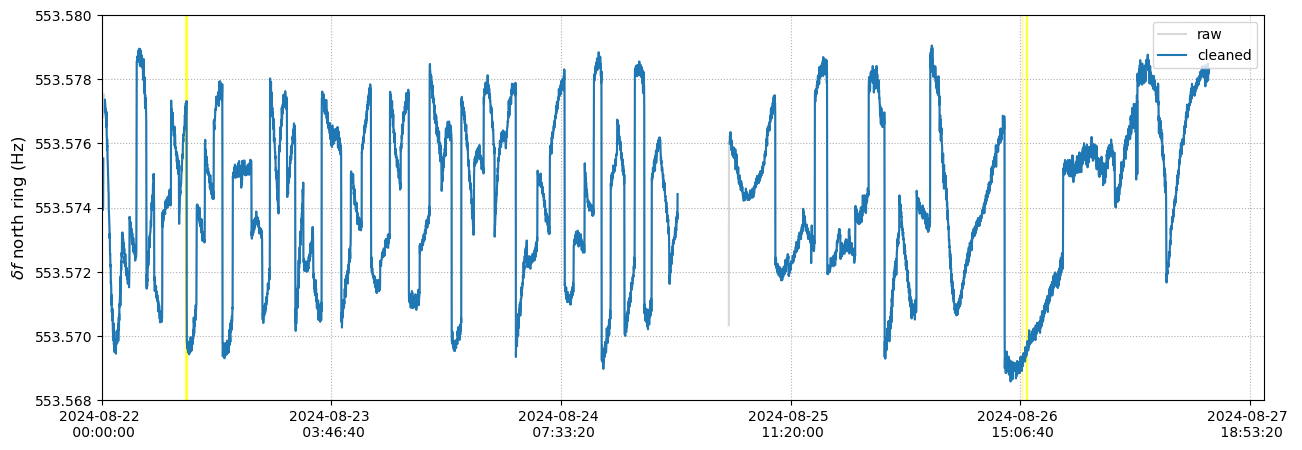

In [26]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring'}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


### Find phase jumps

In [27]:
from functions.get_phase_jumps_sta_lta import get_phase_jumps_sta_lta

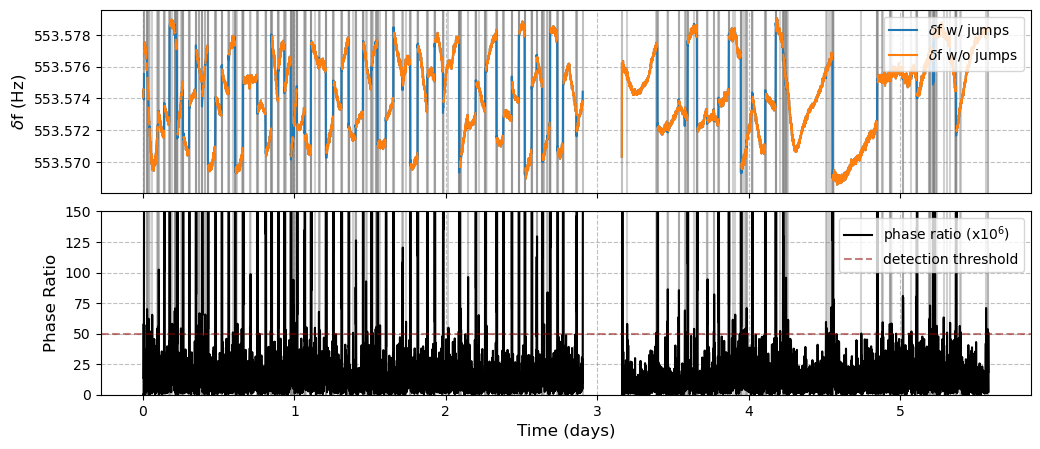

In [28]:
ratio, detect, fig = get_phase_jumps_sta_lta(np.array(bs.fj_fs), np.array(bs.time_sec), 5, 3, amp_threshold=5e-5)

# fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_dejump_example3.png", format="png", dpi=150, bbox_inches='tight')


In [29]:
mask1 = np.where(detect == 1, bs.time1, np.nan)
mask2 = np.where(detect == 1, bs.time2, np.nan)

mask_df = DataFrame()
mask_df['mask1'] = mask1
mask_df['mask2'] = mask2

mask_df = mask_df.dropna()

mask1 = np.array(mask_df.mask1)
mask2 = np.array(mask_df.mask2)

#### Correct phase jumps

In [30]:
from functions.correct_phase_jumps import __correct_phase_jumps

In [31]:
# get index for mlti launches
mlti_sec = [int((UTCDateTime(_t) - config['tbeg'])/config['delta']) for _t in mlti.time_utc]

# add mlti launches to detected jumps for correction
for _i in mlti_sec:
    detect[_i] = 1
    # detect[_i+10] = 1

In [32]:
bs['fj_fs_dejump'] = __correct_phase_jumps(bs.fj_fs_inter, detect)
bs['fj_bs_dejump'] = __correct_phase_jumps(bs.fj_bs_inter, detect)

In [33]:
# plt.plot(bs.fj_fs_dejump)
# plt.plot(bs.fj_bs_dejump)

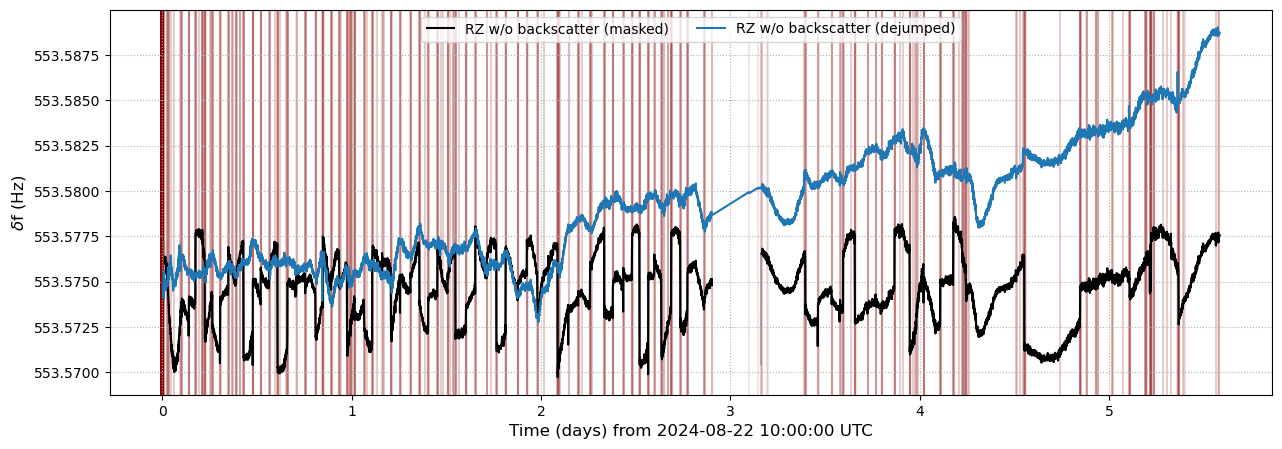

In [34]:
def __makeplot5():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tscale, tunit = 1/86400, "days"

    ax.plot(bs.time_sec*tscale, bs.fj_bs, color="tab:grey", alpha=0.5)
    ax.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="black", label=f"R{config['ring']} w/o backscatter (masked)")
    ax.plot(bs.time_sec*tscale, bs.fj_bs_dejump, color="tab:blue", label=f"R{config['ring']} w/o backscatter (dejumped)")

    for d in detect*bs.time_sec*tscale:
        ax.axvline(d, alpha=0.1, zorder=1, color="darkred")

    ax.ticklabel_format(useOffset=False)

    # ax.set_ylim(447.726, 447.738)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=9, ncol=2)

    ax.set_ylabel("$\delta$f (Hz)", fontsize=font)
    ax.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    plt.show();
    return fig

fig = __makeplot5();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_dejump.png", format="png", dpi=150, bbox_inches='tight')


In [35]:
from functions.multitaper_psd import __multitaper_psd
from scipy.signal import detrend

bs['fj_bs_smooth_inter'] = __interpolate_nan(np.array(bs.fj_bs_smooth))

mode = "linear"

dat1 = detrend(bs.fj_fs_inter, type=mode)
dat2 = detrend(bs.fj_bs_inter, type=mode)
# dat1 = detrend(bs.fj_fs_dejump, type=mode)
# dat2 = detrend(bs.fj_bs_dejump, type=mode)

# dat3 = detrend(bs.fj_bs_smooth_inter, type=mode)

# f1, psd1 = __multitaper_psd(dat1, 60, n_win=10, time_bandwidth=3.5)
# f2, psd2 = __multitaper_psd(dat2, 60, n_win=10, time_bandwidth=3.5)

# f1, psd1 = __welch_psd(dat1, 60, twin_sec=86400)
# f2, psd2 = __welch_psd(dat2, 60, twin_sec=86400)

psd1, f1, pha1 = __get_fft(dat1, 60, window="cosine")
psd2, f2, pha2 = __get_fft(dat2, 60, window="cosine")
# psd3, f3, pha3 = __get_fft(dat3, 60, window="cosine")

# psd1, f1, pha1 = __get_fft(dat1, 60)
# psd2, f2, pha2 = __get_fft(dat2, 60)
# psd3, f3, pha3 = __get_fft(dat3, 60)

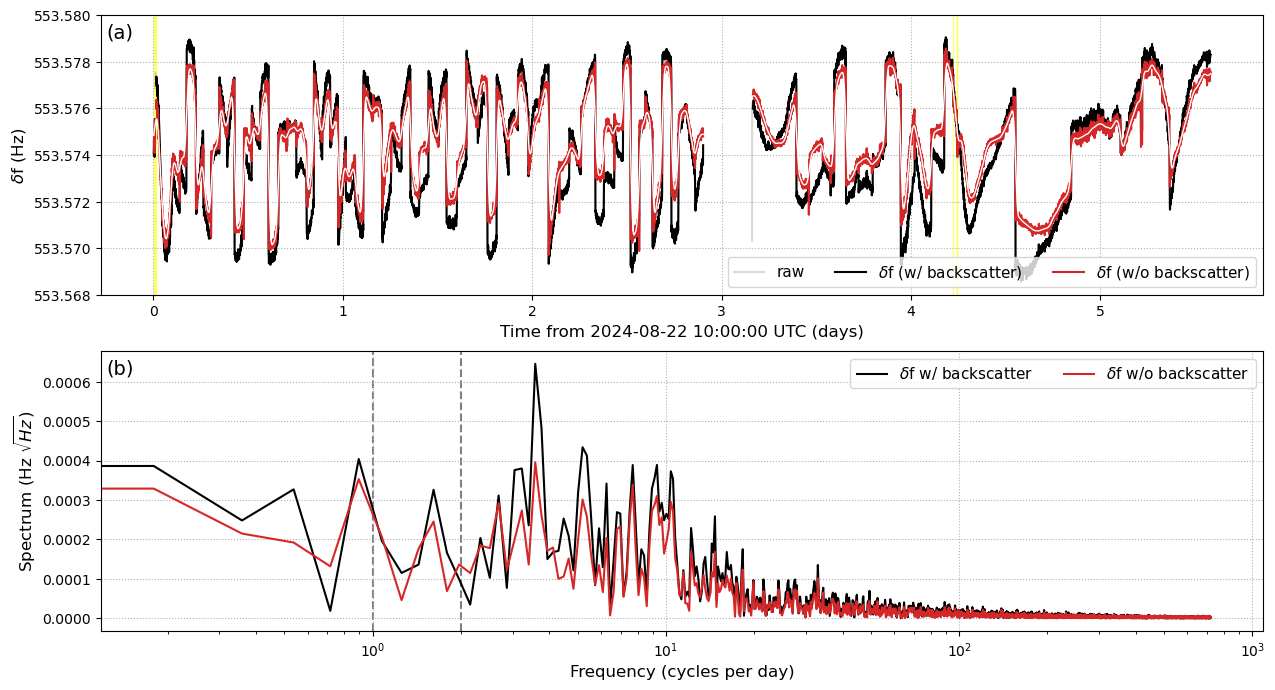

In [36]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1*86400, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].semilogx(f2*86400, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")
    # ax[1].semilogx(f3, psd3, color="tab:grey", label=f"$\delta$f w/o backscatter (smooth)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=4, fontsize=font-1, ncol=3)
    ax[1].legend(loc=1, fontsize=font-1, ncol=3)

    ax[0].set_ylim(flim1, flim2)


    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC ({tunit})", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (cycles per day)", fontsize=font)

    ax[1].axvline(1/(12*3600)*86400, ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600)*86400, ls="--", color="grey", zorder=0)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax[0].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_spectrum_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


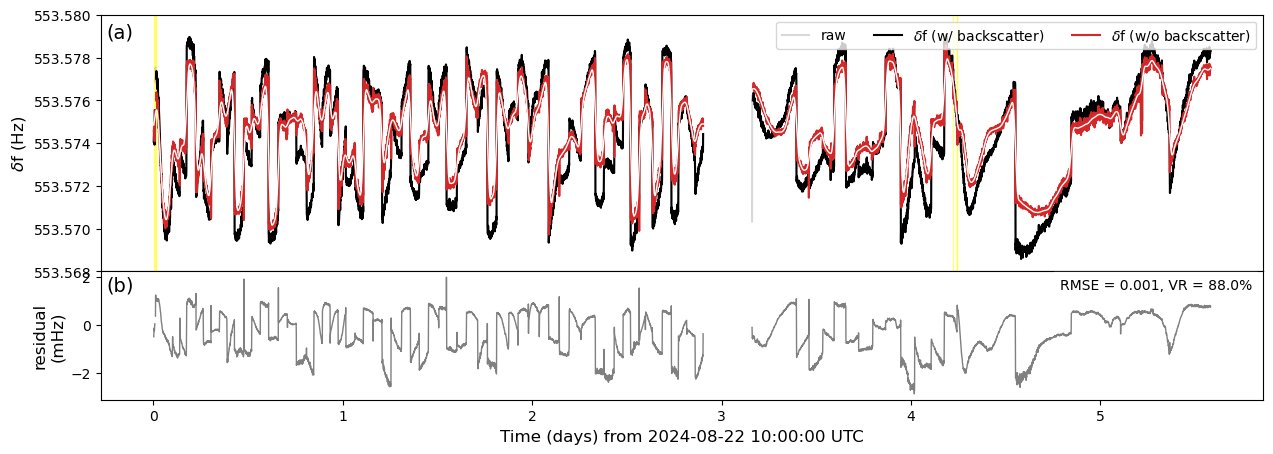

In [37]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        return round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)



    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 1, 3

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    ax1.set_ylim(flim1, flim2)
    ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc=1, ncol=3)

    ax1.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax2.set_ylabel(f"residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, VR = {R}%"
    ax2.text(.99, .95, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2, bbox=dict(facecolor='white', alpha=0.6, edgecolor="w"))

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")

    # ax1.grid(ls=":", zorder=0)
    # ax2.grid(ls=":", zorder=0)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


### Store Data

In [38]:
opath = data_path+"manuscripts/manuscript_romy_drifts/data/"

bs.to_pickle(opath+"bs_fsr.pkl")

## Plot with zoom-in

1368 1872


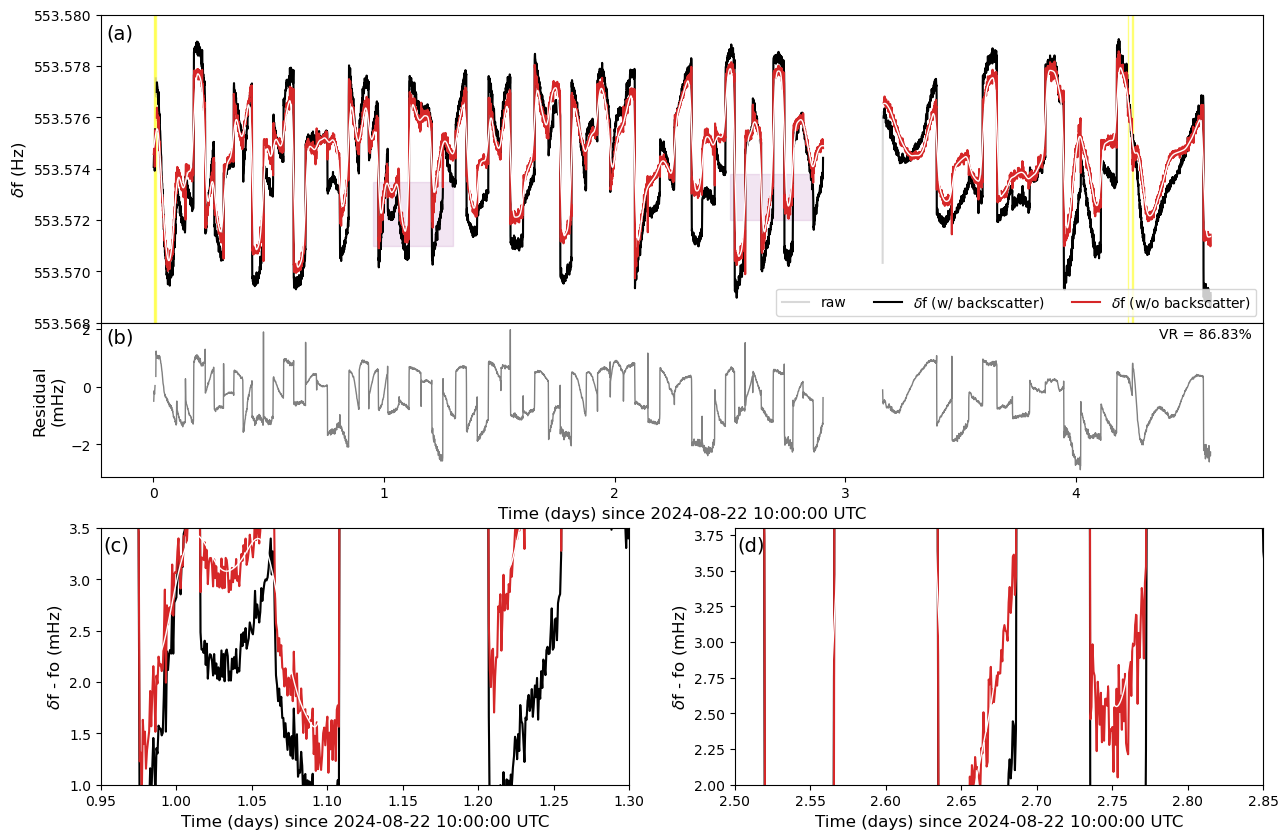

In [32]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        return round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)

    _df = 1/2

    fs0 = 553.57

    fscale, funit = 1e3, "mHz"

    tscale, tunit = 1/86400, "days"

    Ncol, Nrow = 2, 5

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 10))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=1)

    ax1 = fig.add_subplot(gs1[0:2, :])
    ax2 = fig.add_subplot(gs1[2, :])
    ax3 = fig.add_subplot(gs2[3:5, :1])
    ax4 = fig.add_subplot(gs2[3:5, 1:])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs - bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    t31, t32 = 0.95, 1.3 # days
    n31, n32 = int(t31*86400/config['delta']), int(t32*86400/config['delta'])
    print(n31, n32)
    ax3.plot(bs.time_sec[n31:n32]*tscale, (bs.fj_fs[n31:n32]-fs0)*fscale, color="tab:grey", alpha=0.3, label="raw")
    ax3.plot(bs.time_sec[n31:n32]*tscale, (bs.fj_fs_nan[n31:n32]-fs0)*fscale, color="black", label=f"$\delta$f (w/ backscatter)")
    ax3.plot(bs.time_sec[n31:n32]*tscale, (bs.fj_bs_nan[n31:n32]-fs0)*fscale, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax3.plot(bs.time_sec[n31:n32]*tscale, (bs.fj_bs_smooth[n31:n32]-fs0)*fscale, color="w", lw=1)
    ax3.set_xlim(t31, t32)

    t41, t42 = 2.5, 2.85 # days
    n41, n42 = int(t41*86400/config['delta']), int(t42*86400/config['delta'])
    ax4.plot(bs.time_sec[n41:n42]*tscale, (bs.fj_fs[n41:n42]-fs0)*fscale, color="tab:grey", alpha=0.3, label="raw")
    ax4.plot(bs.time_sec[n41:n42]*tscale, (bs.fj_fs_nan[n41:n42]-fs0)*fscale, color="black", label=f"$\delta$f (w/ backscatter)")
    ax4.plot(bs.time_sec[n41:n42]*tscale, (bs.fj_bs_nan[n41:n42]-fs0)*fscale, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax4.plot(bs.time_sec[n41:n42]*tscale, (bs.fj_bs_smooth[n41:n42]-fs0)*fscale, color="w", lw=1)
    ax4.set_xlim(t41, t42)


    ax1.set_ylim(flim1, flim2)
    flim_z1_1, flim_z1_2 = 553.571, 553.5735
    ax3.set_ylim((flim_z1_1-fs0)*fscale, (flim_z1_2-fs0)*fscale)
    flim_z2_1, flim_z2_2 = 553.572, 553.5738
    ax4.set_ylim((flim_z2_1-fs0)*fscale, (flim_z2_2-fs0)*fscale)

    ax1.fill_betweenx([flim_z1_1, flim_z1_2],
                      bs.time_sec[n31]*tscale, bs.time_sec[n32]*tscale,
                      color="purple", alpha=0.1
                     )
    ax1.fill_betweenx([flim_z2_1, flim_z2_2],
                      bs.time_sec[n41]*tscale, bs.time_sec[n42]*tscale,
                      color="purple", alpha=0.1
                     )

    ax1.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax3.set_ylabel(f"$\delta$f - fo ({funit})", fontsize=font)
    ax4.set_ylabel(f"$\delta$f - fo ({funit})", fontsize=font)


    for ax in [ax1, ax3, ax4]:
        ax.ticklabel_format(useOffset=False)

    ax1.legend(loc=4, ncol=3)

    ax2.set_ylabel(f"Residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) since {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax3.set_xlabel(f"Time ({tunit}) since {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax4.set_xlabel(f"Time ({tunit}) since {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"VR = {R}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")

    # from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    # ax1.xaxis.set_major_locator(MultipleLocator(2))
    # ax1.xaxis.set_minor_locator(MultipleLocator(4))

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax3.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax4.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}_zoomin.png",
            format="png", dpi=150, bbox_inches='tight')


## Load Tilt

In [33]:
from functions.conversion_to_tilt import __conversion_to_tilt
from functions.read_yaml import __readYaml

In [34]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

tromy0 = Stream()
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

# tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])


  -> converted data of ROMYT


## Make Stream

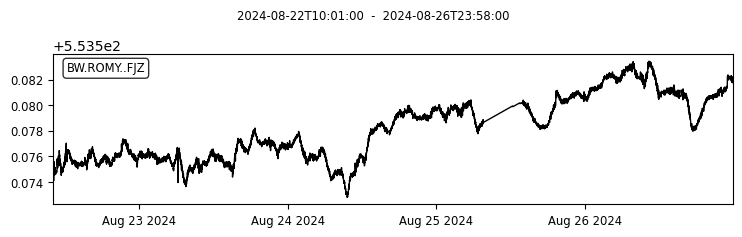

In [35]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

# dff = np.array(bs.fj_fs_inter)
# dff = np.array(bs.fj_bs_inter)
dff = np.array(bs.fj_bs_dejump)

rx = Trace()
rx.data = dff
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

In [36]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

In [37]:
__sagnac_to_tilt(data=None, ring="Z", tilt="n-s")

553.6552182680465

In [38]:
ns = tromy0.copy().select(channel="*N")[0]
ew = tromy0.copy().select(channel="*E")[0]
rr = rx.copy()[0]

rr.data = __sagnac_to_tilt(rr.data, ring=config['ring'], tilt='n-s')

ns.data = __reduce(ns.data, 10)
ew.data = __reduce(ew.data, 10)
rr.data = __reduce(rr.data, 10)

ns.data = __smooth(ns.data, int(3600*ns.stats.sampling_rate))
ew.data = __smooth(ew.data, int(3600*ew.stats.sampling_rate))
rr.data = __smooth(rr.data, int(3600*rr.stats.sampling_rate))

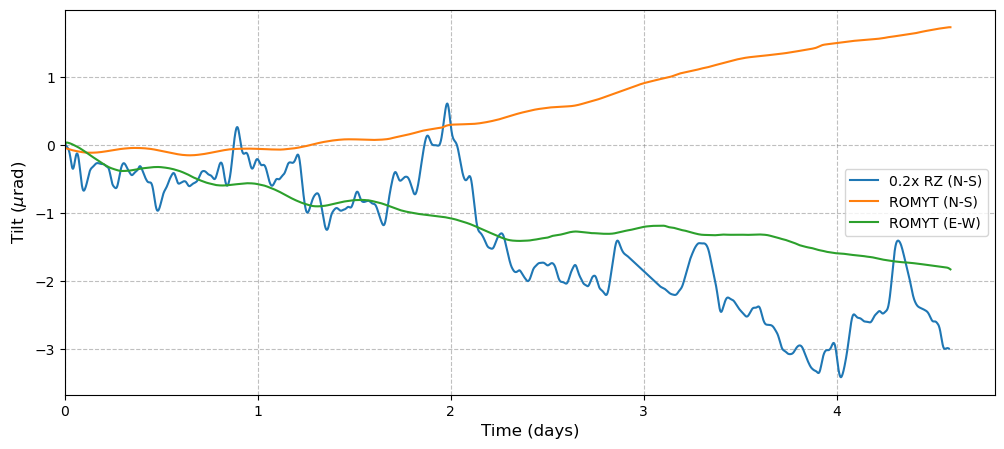

In [39]:
def __makeplot():

    import matplotlib.pyplot as plt

    scaling = 2e-1

    tscale, tunit = 1/86400, "days"

    yscale, yunit = 1e6, "$\mu$rad"

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(rr.times(reftime=config['tbeg'])*tscale, rr.data*scaling*yscale, label=f"{scaling}x RZ (N-S)")
    ax.plot(ns.times(reftime=config['tbeg'])*tscale, ns.data*yscale, label="ROMYT (N-S)")
    ax.plot(ew.times(reftime=config['tbeg'])*tscale, ew.data*yscale, label="ROMYT (E-W)")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=5, fontsize=font-2)

    ax.set_xlim(left=0)

    ax.set_ylabel(f"Tilt ({yunit})", fontsize=font)
    ax.set_xlabel(f"Time ({tunit})", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_tilts_{config['tbeg']}_{config['tend']}.png",
            format="png", dpi=150, bbox_inches='tight')



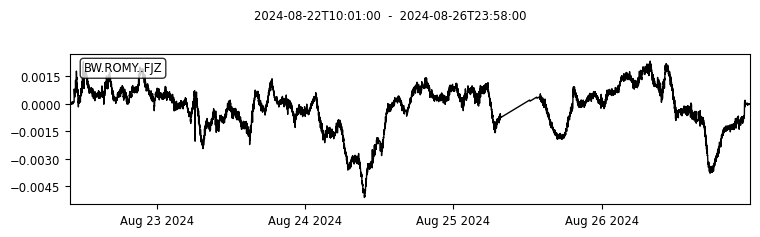

In [40]:
# rx = rx.trim(UTCDateTime("2024-07-05"), UTCDateTime("2024-07-18"))

rx = rx.detrend("linear")
rx = rx.detrend("simple")

rx = rx.taper(0.01, type="cosine")

# rx = rx.filter("bandpass", freqmin=1/(30*3600), freqmax=1/(1*3600), zerophase=True, corners=4)
rx.plot();

In [41]:
# https://www.engineeringtoolbox.com/linear-expansion-coefficients-d_95.html

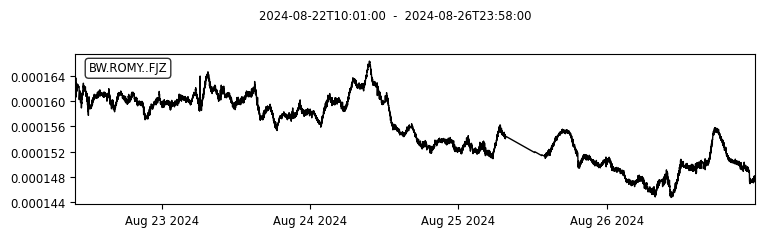

In [42]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

dff = np.array(bs.fj_bs_dejump)

dff_tilt = __sagnac_to_tilt(dff, config['ring'], tilt='n-s')

rx = Trace()
rx.data = dff_tilt
rx.stats.delta = config['delta']
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

In [43]:
def __makeplot():

    import matplotlib.pyplot as plt

    ns = tromy1.copy().select(channel="*N")[0]
    ew = tromy1.copy().select(channel="*E")[0]
    rr = rx.copy()[0]

    scaling = -0.05

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(rr.times(reftime=config['tbeg']), __reduce(rr.data, 10)*scaling)
    ax.plot(ns.times(reftime=config['tbeg']), __reduce(ns.data, 10))
    ax.plot(ew.times(reftime=config['tbeg']), __reduce(ew.data, 10))
    # ax.plot(ew.times(reftime=config['tbeg']), -__reduce(ns.data-ew.data, 10))

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    plt.show();
    return fig

fig = __makeplot();

NameError: name 'tromy1' is not defined

In [ ]:
fmin, fmax = 1/(14*3600), 1/(10*3600)

rxx = rx.copy()

rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=False)

rxx = rxx.resample(5.0)

rxx = rxx.detrend("linear")

rxx = rxx.taper(0.05)

# rxx = rxx.filter("lowpass", freq=fmax, corners=2, zerophase=True)

rxx = rxx.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

# rxx = rxx.resample(10*fmax, no_filter=True)
rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=True)

rxx

rxx.plot();

In [ ]:
tromy = tromy0.copy();

tromy = tromy.merge(fill_value="interpolate");

tromy = tromy.trim(config['tbeg'], config['tend'])
# tromy = tromy.resample(1, no_filter=False)
# tromy = tromy.resample(0.1, no_filter=False)
# tromy = tromy.resample(1/60, no_filter=False)

tromy = tromy.detrend("linear")
tromy = tromy.taper(0.01, type="cosine")
tromy = tromy.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

tromy.plot(equal_scale=False);


In [ ]:
import emd

In [ ]:
plt.plot(bs.fj_bs_inter)

In [ ]:
df = 1/60

data = np.array(bs.fj_fs_inter)

# Run a mask sift
imf = emd.sift.mask_sift(data, max_imfs=3)

IP, IF, IA = emd.spectra.frequency_transform(imf, df, 'nht')

In [ ]:
N = imf.shape[1]

fig, ax = plt.subplots(N, 1)

for n in range(N):
    ax[n].plot(imf[:, n])


In [ ]:
N = IF.shape[1]

fig, ax = plt.subplots(N, 1)

for n in range(N):
    ax[n].plot(IF[:, n])


In [ ]:
f, spectrum = emd.spectra.hilberthuang(IF[:,2], IA[:,2], (.01, 10, 1000))

In [ ]:
plt.semilogx(f, spectrum)

In [ ]:
rot = read("/home/andbro/Downloads/mseed/ROMY_BJU_2023-09-08.mseed")
st = read("/home/andbro/Downloads/mseed/DROMY_FJU_2023-09-08.mseed")

In [ ]:
st, rot

In [ ]:
t1, t2 = UTCDateTime("2023-09-08 22:25"), UTCDateTime("2023-09-08 22:27")

rot = rot.trim(t1, t2)
st = st.trim(t1, t2)

In [ ]:
rot.plot();

In [ ]:
st = st.detrend("linear")

df = st[0].stats.sampling_rate

data = st[0].data

# Run a mask sift
imf = emd.sift.mask_sift(data, max_imfs=4)

IP, IF, IA = emd.spectra.frequency_transform(imf, df, 'nht')

In [ ]:
N = imf.shape[1]

fig, ax = plt.subplots(N, 1)

for n in range(N):
    ax[n].plot(imf[:, n])


In [ ]:
N = IF.shape[1]

fig, ax = plt.subplots(N, 1)

for n in range(N):
    ax[n].plot(IF[:, n])


In [ ]:
plt.plot(IF[:, 2]*IA[:, 2]+IF[:, 3]*IA[:, 3])

In [ ]:
plt.plot(imf[:,2]+imf[:,3])